In [1]:
import yaml
import pandas as pds
import numpy as np
import seaborn as sns
import tarfile
import matplotlib.pyplot as plt
from collections import defaultdict

### create list of obo ontologies from yaml file downloaded from obofoundry.org

In [2]:
with open('obo_ontologies.yml', 'r') as f:
    obo_dict = yaml.safe_load(f)

In [3]:
obo_ids = [o["id"].upper().strip() for o in obo_dict["ontologies"]]
len(obo_ids)

256

In [4]:
# obo_ids[:5] # testing

### simple function identify an RO relation

In [5]:
def is_ro_predicate(name):
    bfo_relations = [
        "BFO:0000050",
        "BFO:0000051",
        "BFO:0000054",
        "BFO:0000055",
        "BFO:0000060",
        "BFO:0000062",
        "BFO:0000063",
        "BFO:0000066",
        "BFO:0000067" 
    ]
    return (name[0:3] == "RO:") or (name in bfo_relations)
    

### get list of obo statistics files from archive

In [6]:
with tarfile.open('statistics.tgz', 'r:*') as tar:
    obo_filenames = [
         name
         for name in tar.getnames()
        
         # check id is an obo ontology: after the '/' and before the '.'
         # e.g. statistics/ncro.statistics.yaml -> NCRO
         if '/' in name and \
            name.split('/')[1].split('.')[0].upper() in obo_ids
     ]

In [7]:
# obo_filenames[:5] # testing

### open each obo statistics tar file

In [8]:
dfs = []
with tarfile.open('statistics.tgz', 'r:*') as tar:
    for member in tar.getmembers():
        if member.isfile() and member.name in obo_filenames:
            # get id ontology: after the '/' and before the '.'
            # e.g. statistics/ncro.statistics.yaml -> NCRO
            ns = member.name.split('/')[1].split('.')[0].upper()
            stat_dict =  yaml.safe_load(tar.extractfile(member).read())
            # predicates = stat_dict['partitions'][ns]['edge_count_by_predicate'].keys
            
            try:
                # partition = stat_dict['partitions'][ns]
                # get partition, and make keys all upper case
                # this is to account for cases such as FBcv
                # FBcv will be transformed to FBCV for search purposes
                partitions = {k.upper():v for k, v in stat_dict['partitions'].items()} 
                partition_ns = partitions[ns]
                
                # used for testing
                # if ns == 'FBCV':
                #     print(partition_ns['edge_count_by_predicate'])
                    
            except KeyError as ke:
                print(f'{ns}: no partition key')
                continue

            try:
                predicates = partition_ns['edge_count_by_predicate'].keys()
                ro_predicates = [p for p in predicates if is_ro_predicate(p)]  # filter for RO predicates
                if len(ro_predicates) > 0:
                    data = {'id': [ns]*len(ro_predicates), 'relation': ro_predicates}
                else:
                    data = {'id': [ns]*len(ro_predicates), 'relation': np.nan}
                
                # if ns == 'PR': print(data) # for testing
                dfs.append(pds.DataFrame(data))
            except KeyError as ke:
                print(f'{ns}: no edge_count_by_predicate')
                continue

CHIRO: no partition key
UPHENO: no edge_count_by_predicate
SBO: no partition key
SWO: no partition key
KISAO: no partition key
DPO: no partition key
EPIO: no partition key
CMO: no partition key
FIDEO: no partition key


In [9]:
df = pds.concat(dfs, ignore_index=True)
df.head(10)

,id,relation
0,NCRO,BFO:0000063
1,NCRO,RO:0000056
2,NCRO,RO:0000057
3,NCRO,RO:0001000
4,SCDO,RO:0003302
5,SCDO,RO:0003303
6,STATO,BFO:0000050
7,STATO,BFO:0000051
8,STATO,BFO:0000054
9,STATO,BFO:0000062


In [10]:
df.query("id == 'FBCV'")

,id,relation
508,FBCV,RO:0000087


In [11]:
df.to_csv('obo_ro_usage.tsv', sep='\t', index=False)

In [12]:
temp_df  = df[['id', 'relation']].query('id != "RO"').drop_duplicates()

In [13]:
len(temp_df)

781

In [14]:
temp_df.id.value_counts()

UBERON         73
GO             66
ENVO           60
FBBT           37
CL             32
               ..
FBCV            1
OHPI            1
OVAE            1
PHIPO           1
WBPHENOTYPE     1
Name: id, Length: 110, dtype: int64

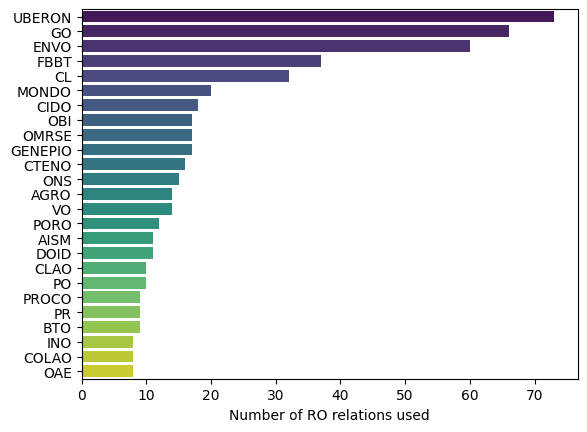

In [15]:
plot_df = pds.DataFrame(temp_df.id.value_counts().head(25).reset_index())
ax = sns.barplot(y='index', x='id', data=plot_df, palette='viridis') #color='steelblue')
ax.set(xlabel='Number of RO relations used', ylabel=None)
plt.show()

---

#### keeping old code for querying ontobee around for posterity

In [84]:
import pandas as pds
from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLWrapper.sparql_dataframe import get_sparql_dataframe

set Ontobee endpoint and return format

In [85]:
endpoint = "http://sparql.hegroup.org/sparql/"

In [86]:
sparql = SPARQLWrapper(endpoint)
sparql.setReturnFormat(JSON)

In [87]:
def make_query(namespace):
    q = """
    prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix owl: <http://www.w3.org/2002/07/owl#>
    prefix merged: <http://purl.obolibrary.org/obo/merged/>
    
    select distinct ?namespace ?relation ?label where 
    {
      # set of BFO relations in RO
      values ?bfo_ro 
      {
        "obo:BFO_0000050" 
        "obo:BFO_0000051" 
        "obo:BFO_0000054" 
        "obo:BFO_0000055" 
        "obo:BFO_0000060" 
        "obo:BFO_0000062" 
        "obo:BFO_0000063" 
        "obo:BFO_0000066" 
        "obo:BFO_0000067" 
      }

      graph merged:%s 
      {
        # define types
        ?s a owl:Class .
        ?o a owl:Class .
        ?r a owl:ObjectProperty .
        
        # find restrictions on class
        ?s (rdfs:subClassOf | owl:equivalentClass)* ?b .
        ?b owl:onProperty+ ?r ;
          (owl:someValuesFrom|owl:allValuesFrom) ?o .
        ?r rdfs:label ?lbl .
      }
      # bind variables as strings using curies for display and ease of use
      bind(replace(str(?r), "http://purl.obolibrary.org/obo/", "obo:") as ?relation)
      bind(replace(str(?s), "http://purl.obolibrary.org/obo/", "obo:") as ?class)
      bind(str(?lbl) as ?label) # removes lang tag and datatype from lable
      bind("%s" as ?namespace)  # display namespace being uses

      
      # filter classes in namespace and RO or BFO/RO relations
      filter(strstarts(?class, "obo:%s_"))
      filter (strstarts(?relation, "obo:RO_") || ?relation in (?bfo_ro))
    }
    """ % (namespace, namespace, namespace)
    return q

In [88]:
# print(make_query("OHD")) # testing

In [89]:
dfs = []
for obo_id in obo_ids:
    try:
        q = make_query(obo_id)
        # dfs.append(get_sparql_dataframe(endpoint, q)) # uncomment to get data
    except Exception as e:
        print(f'{obo_id} error:', e)